## Occlusion Experiments for object segmentation

This notebook tries to replicate the method and results of occlusion experiments conducted by M. Zeiler et al in their paper <em>"Visualising and understanding convolutional neural networks".</em> 

In this paper, the authors zero out parts of the unput image, feed it into a trained ConvNet for detection and monitor the output of the classifier. This leads to the generation of a heat-map whose values are a function of the classifier output when those parts were occluded in the original input image. 


In [11]:
# the usual imports
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimage
import json
from copy import deepcopy

# DNN specific imports
from nnet.vgg16 import VGG16
from keras.preprocessing import image
from nnet.imagenet_utils import preprocess_input, decode_predictions

ModuleNotFoundError: No module named 'tensorflow'

In [10]:
from PIL import Image

def imresize(arr, size):
    img = Image.fromarray(arr)
    img = img.resize(size, Image.ANTIALIAS)
    return np.array(img)

In [ ]:
# to reformat images as (batchsize, 3, 224, 224)
def reformat(input):

    x = np.zeros((len(input), 3, 224, 224))
    for i in xrange(len(input)):
        x[i, 0,:,:] = input[i][:,:,0]
        x[i, 1,:,:] = input[i][:,:,1]
        x[i, 2,:,:] = input[i][:,:,2]
    
    # Note: currently using RGB format

    return x

### Occlusion Generator class
This class lazily generates occluded images at run time. This is done because preloading a set of occluded images would just eat up my ram.  

In [3]:
class OcclusionGenerator(object):
     
    def __init__(self, img, boxsize=10, step=10, prepocess=True):
        ''' Initializations '''
        self.img = img
        self.boxsize = boxsize
        self.step = step 
        self.i = 0
        self.j = 0
    

    def flow(self):
        ''' Return a single occluded image and its location '''
        if self.i + self.boxsize > self.img.shape[0]:
            return None, None, None
        
        retImg = np.copy(self.img)
        retImg[self.i:self.i+self.boxsize, self.j:self.j+self.boxsize] = 0.0 

        old_i = deepcopy(self.i) 
        old_j = deepcopy(self.j)
        
        # update indices
        self.j = self.j + self.step
        if self.j+self.boxsize>self.img.shape[1]: #reached end
            self.j = 0 # reset j
            self.i = self.i + self.step # go to next row
        
        return retImg, old_i, old_j

    def gen_minibatch(self, batchsize=10):
        ''' Returns a minibatch of images of size <=batchsize '''
        
        # list of occluded images
        occ_imlist = []
        locations = []
        for i in xrange(batchsize):
            occimg, i, j = self.flow()
            if occimg is not None:
                occ_imlist.append(occimg)
                locations.append([i,j])

        if len(occ_imlist)==0: # no data
            return None,None
        else:
            # convert list to numpy array and pre-process input (0 mean centering)
            x = preprocess_input(reformat(occ_imlist))
            return x, locations 


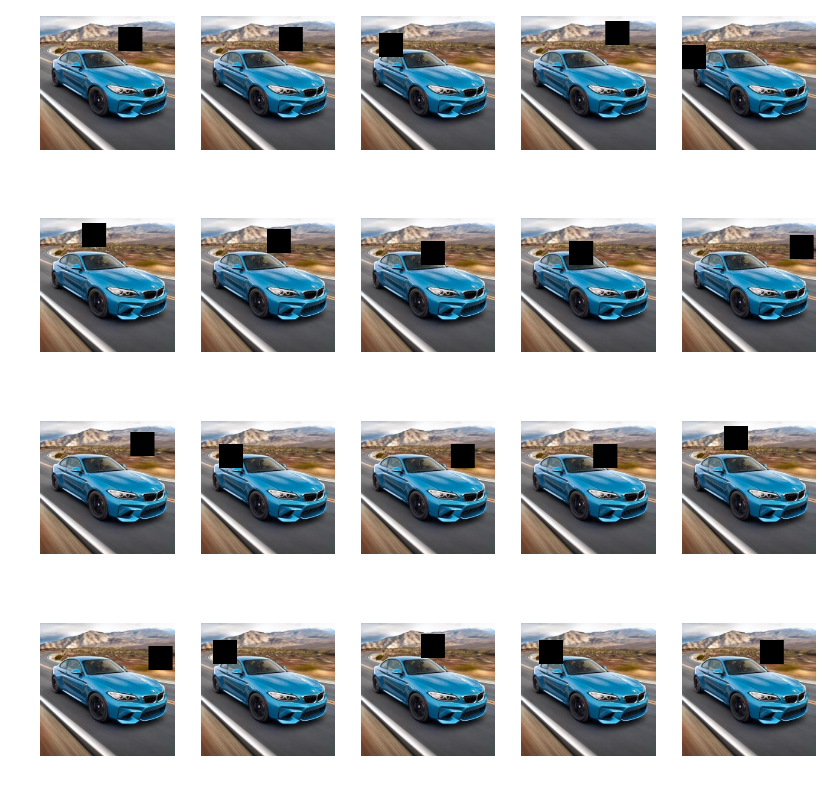

In [12]:
# testing out the occlusion generator class
img = mpimage.imread("./images/car.jpeg")
img = imresize(img, (224,224,3))
occ = OcclusionGenerator(img, 40, 10, False)
occList = []
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10, 10)
for i in xrange(100):
    occList.append(occ.flow()[0])
for i in xrange(20):
    plt.subplot(4,5,i)
    plt.imshow(occList[np.random.randint(len(occList))]); plt.axis("off")
plt.show()
del occ,img,occList

In [17]:
# this function takes a list of heatmaps and merges them into one single heatmap
def post_process(heatmap):

    # postprocessing
    total = heatmap[0]
    for val in heatmap[1:]:
        total = total + val
    
    return total

In [18]:
#### This is the meat of the program. It generates the heatmap for the given image location ####

def gen_heatmap(fileloc, boxsize, step, verbose=True, savetodisk=False):

    # load up image 
    img = mpimage.imread(fileloc)
    img = imresize(img, (224,224,3))
    if verbose:
        plt.imshow(img); plt.axis("off")
        plt.show()

    # classify image (w/o occlusions)
    model = VGG16(weights='imagenet')
    x = reformat([img])
    x = preprocess_input(x)
    preds = model.predict(x)
    correct_class_index = np.argmax(preds[0])

    # load correct label text 
    f = open("imagenet_class_index.json","rt")
    imagenet_labels = json.load(f)
    f.close()
    correct_class_label = imagenet_labels[str(correct_class_index)][1]
    if verbose:
        print correct_class_label

    # generate occluded images and location of mask
    occ = OcclusionGenerator(img, boxsize, step, True)

    # scores of occluded image
    heatmap = []
    index = 0
    while True:

        # get minibatch of data
        x, locations = occ.gen_minibatch(batchsize=10)

        if x is not None:

            #predict 
            op = model.predict(x)

            #unpack prediction values 
            for i in xrange(x.shape[0]):
                score = op[i][correct_class_index]
                r,c = locations[i] 
                scoremap = np.zeros((224,224))
                scoremap[r : r+occ.boxsize, c : c+occ.boxsize] = score
                heatmap.append(scoremap)

            if verbose:
                print '..minibatch completed'
        else:
            break

    if savetodisk:
        #save heatmap to disk 
        import cPickle as pickle
        f = open("heatmap", 'wb')
        pickle.dump(heatmap, f)
        f.close()

    return heatmap, correct_class_index, correct_class_label

In [19]:
# run the program on image of a golden retriever
heatmapList, index, label = gen_heatmap("./images/golden_retriever.jpeg", 20, 10, False)
processed   = post_process(heatmapList)

K.image_dim_ordering: th


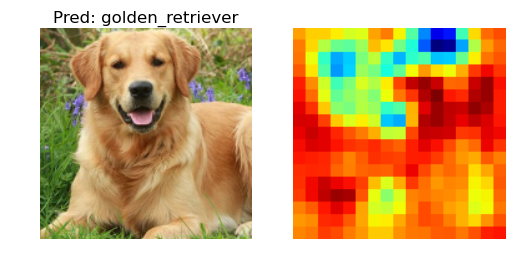

In [20]:
%matplotlib inline
img = mpimage.imread('./images/golden_retriever.jpeg')
img = imresize(img, (224,224,3))
plt.subplot(121)
plt.imshow(img[30:200, 30:200]); plt.axis("off")
plt.title("Pred: "+label)
plt.subplot(122)
plt.imshow(processed[30:200, 30:200]); plt.axis("off")
plt.show()

There is a very clear indication that the model looks at the snout, ears, eyes and the paws of the dog to categorize it as a golden retriever.  